# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


[2018-01-22 23:10:02,350] Making new env: CartPole-v1


Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [4]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [10]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
loss = 0
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 7.0 Training loss: 1.2631 Explore P: 0.9993
Episode: 2 Total reward: 10.0 Training loss: 1.2526 Explore P: 0.9983
Episode: 3 Total reward: 21.0 Training loss: 1.1789 Explore P: 0.9962
Episode: 4 Total reward: 22.0 Training loss: 1.1641 Explore P: 0.9941
Episode: 5 Total reward: 29.0 Training loss: 1.2260 Explore P: 0.9912
Episode: 6 Total reward: 47.0 Training loss: 1.0893 Explore P: 0.9866
Episode: 7 Total reward: 16.0 Training loss: 1.2337 Explore P: 0.9851
Episode: 8 Total reward: 12.0 Training loss: 1.2403 Explore P: 0.9839
Episode: 9 Total reward: 19.0 Training loss: 1.1580 Explore P: 0.9820
Episode: 10 Total reward: 18.0 Training loss: 1.2473 Explore P: 0.9803
Episode: 11 Total reward: 12.0 Training loss: 1.3223 Explore P: 0.9791
Episode: 12 Total reward: 17.0 Training loss: 1.3041 Explore P: 0.9775
Episode: 13 Total reward: 21.0 Training loss: 1.4259 Explore P: 0.9755
Episode: 14 Total reward: 18.0 Training loss: 1.4840 Explore P: 0.9737
Episode: 15 Tota

Episode: 117 Total reward: 26.0 Training loss: 12.8944 Explore P: 0.7850
Episode: 118 Total reward: 36.0 Training loss: 310.6999 Explore P: 0.7822
Episode: 119 Total reward: 19.0 Training loss: 304.0230 Explore P: 0.7807
Episode: 120 Total reward: 22.0 Training loss: 12.2494 Explore P: 0.7790
Episode: 121 Total reward: 11.0 Training loss: 202.4679 Explore P: 0.7782
Episode: 122 Total reward: 15.0 Training loss: 10.3751 Explore P: 0.7770
Episode: 123 Total reward: 13.0 Training loss: 12.5228 Explore P: 0.7760
Episode: 124 Total reward: 15.0 Training loss: 9.3937 Explore P: 0.7749
Episode: 125 Total reward: 11.0 Training loss: 197.4430 Explore P: 0.7740
Episode: 126 Total reward: 38.0 Training loss: 217.7054 Explore P: 0.7711
Episode: 127 Total reward: 15.0 Training loss: 11.7126 Explore P: 0.7700
Episode: 128 Total reward: 13.0 Training loss: 11.2286 Explore P: 0.7690
Episode: 129 Total reward: 14.0 Training loss: 450.8345 Explore P: 0.7679
Episode: 130 Total reward: 16.0 Training loss:

Episode: 231 Total reward: 21.0 Training loss: 45.3775 Explore P: 0.6512
Episode: 232 Total reward: 27.0 Training loss: 2.0639 Explore P: 0.6494
Episode: 233 Total reward: 16.0 Training loss: 97.0695 Explore P: 0.6484
Episode: 234 Total reward: 13.0 Training loss: 92.0569 Explore P: 0.6476
Episode: 235 Total reward: 13.0 Training loss: 42.1841 Explore P: 0.6468
Episode: 236 Total reward: 7.0 Training loss: 66.2787 Explore P: 0.6463
Episode: 237 Total reward: 9.0 Training loss: 2.4244 Explore P: 0.6457
Episode: 238 Total reward: 21.0 Training loss: 1.7230 Explore P: 0.6444
Episode: 239 Total reward: 11.0 Training loss: 62.1517 Explore P: 0.6437
Episode: 240 Total reward: 12.0 Training loss: 89.2468 Explore P: 0.6430
Episode: 241 Total reward: 12.0 Training loss: 239.6846 Explore P: 0.6422
Episode: 242 Total reward: 10.0 Training loss: 46.9622 Explore P: 0.6416
Episode: 243 Total reward: 16.0 Training loss: 48.5477 Explore P: 0.6406
Episode: 244 Total reward: 16.0 Training loss: 50.3463 

Episode: 347 Total reward: 13.0 Training loss: 0.9020 Explore P: 0.5491
Episode: 348 Total reward: 28.0 Training loss: 34.8035 Explore P: 0.5476
Episode: 349 Total reward: 14.0 Training loss: 19.6178 Explore P: 0.5468
Episode: 350 Total reward: 9.0 Training loss: 51.1482 Explore P: 0.5464
Episode: 351 Total reward: 13.0 Training loss: 1.4935 Explore P: 0.5457
Episode: 352 Total reward: 35.0 Training loss: 55.8398 Explore P: 0.5438
Episode: 353 Total reward: 8.0 Training loss: 34.1574 Explore P: 0.5434
Episode: 354 Total reward: 45.0 Training loss: 34.7372 Explore P: 0.5410
Episode: 355 Total reward: 80.0 Training loss: 28.3319 Explore P: 0.5367
Episode: 356 Total reward: 99.0 Training loss: 98.6875 Explore P: 0.5315
Episode: 357 Total reward: 49.0 Training loss: 0.4848 Explore P: 0.5290
Episode: 358 Total reward: 86.0 Training loss: 0.9164 Explore P: 0.5246
Episode: 359 Total reward: 27.0 Training loss: 1.0815 Explore P: 0.5232
Episode: 360 Total reward: 26.0 Training loss: 26.0792 Exp

Episode: 460 Total reward: 127.0 Training loss: 42.1077 Explore P: 0.3047
Episode: 461 Total reward: 106.0 Training loss: 1.4820 Explore P: 0.3016
Episode: 462 Total reward: 168.0 Training loss: 43.7041 Explore P: 0.2967
Episode: 463 Total reward: 48.0 Training loss: 2.0660 Explore P: 0.2953
Episode: 464 Total reward: 60.0 Training loss: 2.0814 Explore P: 0.2936
Episode: 465 Total reward: 68.0 Training loss: 35.5432 Explore P: 0.2917
Episode: 466 Total reward: 52.0 Training loss: 3.6233 Explore P: 0.2903
Episode: 467 Total reward: 45.0 Training loss: 42.2315 Explore P: 0.2890
Episode: 468 Total reward: 13.0 Training loss: 55.1949 Explore P: 0.2886
Episode: 469 Total reward: 79.0 Training loss: 2.0060 Explore P: 0.2864
Episode: 470 Total reward: 99.0 Training loss: 56.0545 Explore P: 0.2837
Episode: 471 Total reward: 104.0 Training loss: 2.6408 Explore P: 0.2809
Episode: 472 Total reward: 112.0 Training loss: 1.2147 Explore P: 0.2779
Episode: 473 Total reward: 50.0 Training loss: 62.228

Episode: 605 Total reward: 38.0 Training loss: 0.4500 Explore P: 0.0711
Episode: 606 Total reward: 29.0 Training loss: 0.3967 Explore P: 0.0710
Episode: 607 Total reward: 54.0 Training loss: 0.4150 Explore P: 0.0706
Episode: 608 Total reward: 35.0 Training loss: 0.3972 Explore P: 0.0704
Episode: 609 Total reward: 29.0 Training loss: 0.2046 Explore P: 0.0702
Episode: 610 Total reward: 40.0 Training loss: 0.5558 Explore P: 0.0700
Episode: 611 Total reward: 34.0 Training loss: 0.4924 Explore P: 0.0698
Episode: 612 Total reward: 27.0 Training loss: 0.5266 Explore P: 0.0696
Episode: 613 Total reward: 33.0 Training loss: 0.3913 Explore P: 0.0694
Episode: 614 Total reward: 25.0 Training loss: 1.1727 Explore P: 0.0693
Episode: 615 Total reward: 20.0 Training loss: 0.5004 Explore P: 0.0692
Episode: 616 Total reward: 26.0 Training loss: 0.3287 Explore P: 0.0690
Episode: 617 Total reward: 51.0 Training loss: 0.4917 Explore P: 0.0687
Episode: 618 Total reward: 62.0 Training loss: 0.4693 Explore P:

Episode: 765 Total reward: 99.0 Training loss: 0.5371 Explore P: 0.0204
Episode: 768 Total reward: 99.0 Training loss: 0.9042 Explore P: 0.0199
Episode: 771 Total reward: 99.0 Training loss: 0.8888 Explore P: 0.0194
Episode: 774 Total reward: 99.0 Training loss: 1.2515 Explore P: 0.0190
Episode: 775 Total reward: 30.0 Training loss: 0.9245 Explore P: 0.0189
Episode: 776 Total reward: 25.0 Training loss: 668.5348 Explore P: 0.0189
Episode: 777 Total reward: 24.0 Training loss: 0.9269 Explore P: 0.0189
Episode: 778 Total reward: 22.0 Training loss: 2.2765 Explore P: 0.0189
Episode: 779 Total reward: 20.0 Training loss: 1.8160 Explore P: 0.0189
Episode: 780 Total reward: 21.0 Training loss: 2.1799 Explore P: 0.0188
Episode: 781 Total reward: 22.0 Training loss: 2.1431 Explore P: 0.0188
Episode: 782 Total reward: 19.0 Training loss: 1.1447 Explore P: 0.0188
Episode: 783 Total reward: 15.0 Training loss: 512.8853 Explore P: 0.0188
Episode: 784 Total reward: 19.0 Training loss: 3.5316 Explor

Episode: 903 Total reward: 99.0 Training loss: 3.1897 Explore P: 0.0146
Episode: 906 Total reward: 99.0 Training loss: 1.7336 Explore P: 0.0144
Episode: 909 Total reward: 99.0 Training loss: 3.3589 Explore P: 0.0142
Episode: 912 Total reward: 99.0 Training loss: 148.8777 Explore P: 0.0140
Episode: 915 Total reward: 99.0 Training loss: 2.4766 Explore P: 0.0138
Episode: 918 Total reward: 99.0 Training loss: 0.4347 Explore P: 0.0136
Episode: 921 Total reward: 99.0 Training loss: 5.8701 Explore P: 0.0134
Episode: 924 Total reward: 99.0 Training loss: 124.8032 Explore P: 0.0132
Episode: 927 Total reward: 54.0 Training loss: 0.7908 Explore P: 0.0131
Episode: 930 Total reward: 99.0 Training loss: 3.0435 Explore P: 0.0130
Episode: 933 Total reward: 99.0 Training loss: 1.3933 Explore P: 0.0128
Episode: 936 Total reward: 99.0 Training loss: 0.9397 Explore P: 0.0127
Episode: 939 Total reward: 99.0 Training loss: 266.6754 Explore P: 0.0125
Episode: 942 Total reward: 99.0 Training loss: 0.5663 Expl

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

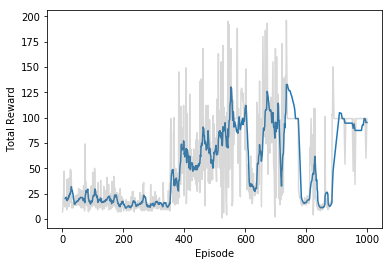

In [12]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0,0.5,'Total Reward')




![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.